In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import seaborn as sns
import numpy as np


### Cargar Datos

In [3]:
df = pd.read_csv('2022 MLB Player Stats - Pitching.csv', delimiter=';')

## Ejercicio 1

### Relación lineal o monótona con la variable **FIP**.

                                 OLS Regression Results                                
Dep. Variable:                    FIP   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              1468.
Date:                Fri, 16 Jun 2023   Prob (F-statistic):                    1.12e-37
Time:                        11:58:42   Log-Likelihood:                         -14.752
No. Observations:                  39   AIC:                                      35.50
Df Residuals:                      36   BIC:                                      40.49
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

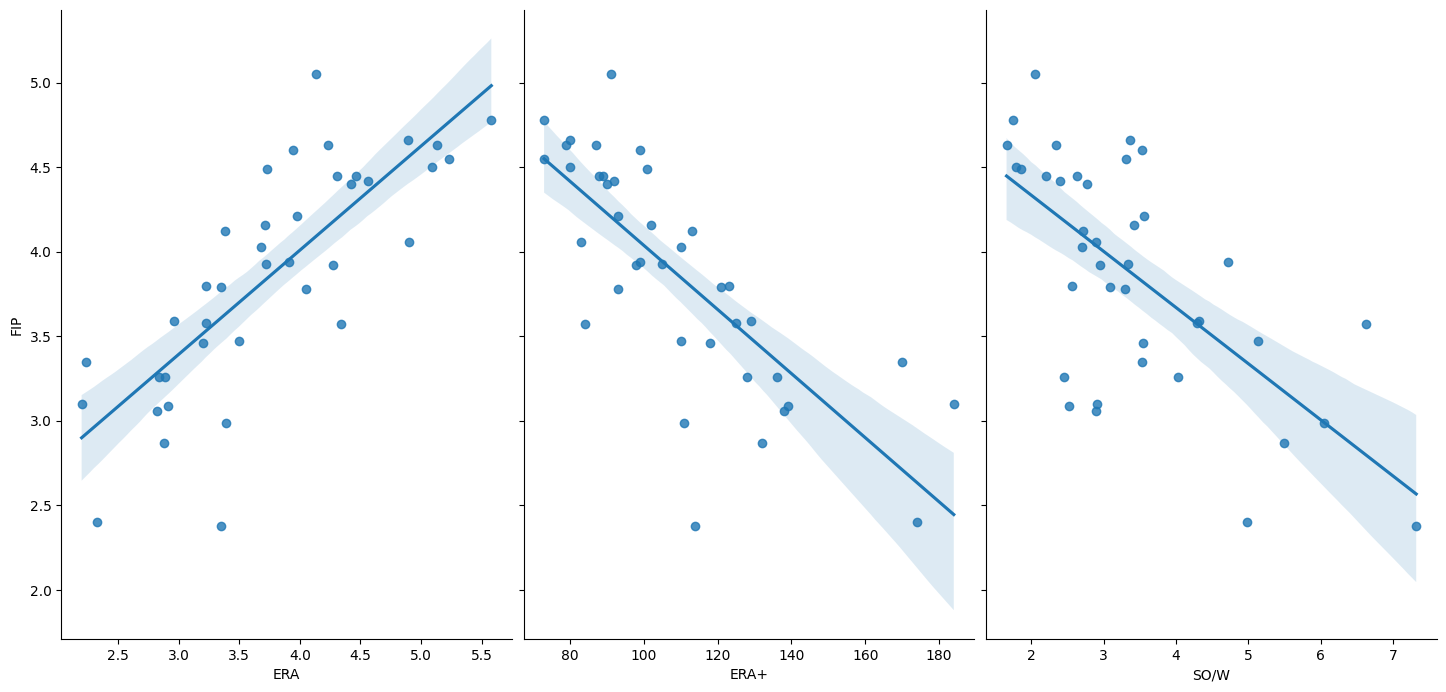

In [14]:
# Filtrando aquellos jugadores de la Liga Americana que hayan recibido más de 120 hits
al = df.loc[df['Lg'] == 'AL']
al120h = al.loc[al['H'] > 120]

al120h_num = al120h.select_dtypes(include=[np.number])

model, X = stepwise(al120h_num, 'FIP', 3)

# print graphics
sns.pairplot(al120h_num, 
             x_vars=[column for column in X], 
             y_vars='FIP', height=7, aspect=0.7, kind='reg')

print(model.summary())

In [4]:
def check_assumptions(model, X):
    resid = model.resid
    X = sm.add_constant(X)
    assumptions = True

    # Media de los residuos
    mn = np.mean(resid)
    assumptions = assumptions and (abs(mn) < 0.05)

    # Independencia de los residuos
    # Prueba de Durbin-Watson
    dw = durbin_watson(resid)
    assumptions = assumptions and (dw > 1.5 and dw < 2.5)
    
    # Homocedasticidad
    # Prueba de Breusch-Pagan
    bp = het_breuschpagan(resid, X)
    assumptions = assumptions and (bp[1] > 0.05)

    # Normalidad de los residuos
    # Prueba de Shapiro-Wilk
    sw = shapiro(resid)
    assumptions = assumptions and (sw[1] > 0.05)

    return assumptions

In [5]:
def compare_models(model1, model2):
    # Calcular R-cuadrado ajustado
    r1_adj = model1.rsquared_adj
    r2_adj = model2.rsquared_adj

    # Calcular la raíz del error cuadrático medio (RMSE)
    rmse1 = np.sqrt(model1.mse_model)
    rmse2 = np.sqrt(model2.mse_model)

    return (r1_adj > r2_adj) and (rmse1 < rmse2)

In [6]:
def stepwise(df, var, t_values=3):
    not_used = order_by_correlation(df, var)
    used = [] + [not_used[0]]
    not_used = not_used[1:]
    X = [df[used[0]]]
    X = pd.concat(X, axis=1)
    y = df[var]
    model = sm.OLS(y, X).fit()
    for i in range(0, len(not_used)-1):
        new_X = [df[variable] for variable in used + [not_used[i]]]
        new_X = pd.concat(new_X, axis=1)
        new_model = sm.OLS(y, new_X).fit()
        if compare_models(new_model, model):
            used = used + [not_used[i]]
            not_used = not_used[:i] + not_used[i+1:]
            model = new_model
            X = new_X   
            i = 0
        if len(used) == t_values:
            if check_assumptions(model, X):
                return model, X
        if i == len(not_used)-2:
            if len(used) == 1:
                return model, X
            used = used[:-1]
            i = 0

def order_by_correlation(df, var):
    rho = df.corr()
    ans = [variable for variable in df if variable != var]
    ans.sort(key=lambda x: abs(rho[x][var]), reverse=True)
    return ans

In [ ]:
rho = al120h_num.corr()

finaldf = [al120h_num[variable] for variable in 
           al120h_num if abs(rho['FIP'][variable]) > 0.7]
finaldf = pd.concat(finaldf, axis=1)

X = [finaldf[variable] for variable in finaldf if variable != 'FIP']
X = pd.concat(X, axis=1)
y = finaldf['FIP']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

for column in X:
    sm.graphics.plot_regress_exog(model, column, fig=plt.figure(figsize=(12, 8)))

print(model.summary())

## Ejercicio 2

### Análisis exploratorio de la variable **Age**, de los jugadores de la liga americana 

In [ ]:
nl = df.loc[df['Lg'] == 'NL']

age = nl['Age']
# Calcular estadísticos descriptivos univariados
mean = age.mean()  # media
median = age.median()  # mediana
mode = age.mode()  # moda
std = age.std()  # desviación estándar
rank = age.max() - age.min()  # rango
quantile = age.quantile([0.25, 0.5, 0.75])  # cuartiles
iqr = quantile[0.75] - quantile[0.25]  # rango intercuartílico


# Mostrar resultados
print('Estadísticos descriptivos univariados')
print('Media:', mean)
print('Mediana:', median)
print('Moda:', mode)
print('Desviación estándar:', std)
print('Rango:', rank)
print('Cuartiles:', quantile)
print('Rango intercuartílico:', iqr)
# Crear histograma
plt.hist(age, bins=10, color='blue')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de edad')

# Crear diagrama de caja
plt.figure()
plt.boxplot(age, vert=False)
plt.xlabel('Edad')
plt.title('Diagrama de caja de edad')

# Mostrar gráficos
plt.show()


In [ ]:
def mean_age(f, age, nl):
    # Hacer ANOVA de un factor si hay más de dos equipos
    if len(f.unique()) > 2:
        # Crear el modelo lineal
        modelo = ols('age ~ f', data=nl).fit()

        # Crear la tabla ANOVA
        tabla = sm.stats.anova_lm(modelo, typ=2)

        # Obtener el valor p del test F
        p = tabla['PR(>F)'][0]

        # Mostrar el resultado
        print('ANOVA de un factor')
        print(tabla)
        print('El valor p es', p)

        # Si el valor p es menor que 0.05, rechazar la hipótesis nula de que las medias son iguales
        if p < 0.05:
            print('Hay diferencias significativas entre las medias de los equipos')
        else:
            print('No hay diferencias significativas entre las medias de los equipos')

    # Hacer test t si hay solo dos equipos
    else:
        # Obtener el valor t y el valor p del test t
        t, p = stats.ttest_ind(
            age[f == f.unique()[0]], age[f == f.unique()[1]])

        # Mostrar el resultado
        print('Test t para muestras independientes')
        print('El valor t es', t)
        print('El valor p es', p)

        # Si el valor p es menor que 0.05, rechazar la hipótesis nula de que las medias son iguales
        if p < 0.05:
            print('Hay diferencias significativas entre las medias de los equipos')
        else:
            print('No hay diferencias significativas entre las medias de los equipos')


# Seleccionar factor
f = nl['Tm']

mean_age(f, age, nl)


In [ ]:
new_nl=nl[nl['Tm'].isin(['PIT', 'SDP', 'WSN','ATL'])]
f = new_nl['Tm']
new_age=new_nl['Age']
mean_age(f,new_age,new_nl)


In [ ]:
# Agrupar por equipo y calcular medias
new_nl = nl.groupby('Tm').mean()

# Transponer el dataframe
new_nl = new_nl.transpose()

# Convertir a array de numpy
X = new_nl.to_numpy()

# Reducir la dimensión a 2 componentes usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear el árbol jerárquico usando AgglomerativeClustering con 4 clústeres
ac = AgglomerativeClustering(n_clusters=4)
C = ac.fit_predict(X_pca)

# Asignar clústeres a equipos
clusters = dict(zip(new_nl.columns, C))

# Visualizar los clústeres usando un gráfico de dispersión con seaborn
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=C, palette='Set1')
plt.show()
